In [7]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [61]:
bs = 128
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(132),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [62]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 128, 128])

In [63]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [64]:
from jcopdl.layers import conv_block, linear_block

In [65]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16,32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn. Sequential(
            linear_block(4096, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [66]:
config = set_config({
    "batch_size": bs, 
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [67]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [68]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6946 | Test_cost  = 0.6903 | Train_score = 0.5190 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6864 | Test_cost  = 0.6725 | Train_score = 0.5540 | Test_score = 0.5850 |




Epoch     3
Train_cost  = 0.6482 | Test_cost  = 0.5862 | Train_score = 0.6600 | Test_score = 0.7575 |




Epoch     4
Train_cost  = 0.5388 | Test_cost  = 0.6513 | Train_score = 0.7510 | Test_score = 0.6725 |
==> EarlyStop patience =  1 | Best test_score: 0.7575




Epoch     5
Train_cost  = 0.5323 | Test_cost  = 0.4876 | Train_score = 0.7440 | Test_score = 0.7800 |




Epoch     6
Train_cost  = 0.5099 | Test_cost  = 0.4684 | Train_score = 0.7450 | Test_score = 0.7800 |
==> EarlyStop patience =  1 | Best test_score: 0.7800




Epoch     7
Train_cost  = 0.4549 | Test_cost  = 0.4121 | Train_score = 0.8040 | Test_score = 0.8050 |




Epoch     8
Train_cost  = 0.4350 | Test_cost  = 0.3944 | Train_score = 0.8040 | Test_score = 0.8375 |




Epoch     9
Train_cost  = 0.4251 | Test_cost  = 0.3803 | Train_score = 0.8000 | Test_score = 0.8175 |
==> EarlyStop patience =  1 | Best test_score: 0.8375




Epoch    10
Train_cost  = 0.4053 | Test_cost  = 0.3515 | Train_score = 0.8200 | Test_score = 0.8450 |




Epoch    11
Train_cost  = 0.3751 | Test_cost  = 0.3243 | Train_score = 0.8350 | Test_score = 0.8550 |




Epoch    12
Train_cost  = 0.3611 | Test_cost  = 0.3609 | Train_score = 0.8450 | Test_score = 0.8075 |
==> EarlyStop patience =  1 | Best test_score: 0.8550




Epoch    13
Train_cost  = 0.3386 | Test_cost  = 0.2824 | Train_score = 0.8450 | Test_score = 0.8950 |




Epoch    14
Train_cost  = 0.3016 | Test_cost  = 0.2603 | Train_score = 0.8740 | Test_score = 0.9000 |




Epoch    15
Train_cost  = 0.2958 | Test_cost  = 0.2547 | Train_score = 0.8720 | Test_score = 0.8925 |
==> EarlyStop patience =  1 | Best test_score: 0.9000




Epoch    16
Train_cost  = 0.2927 | Test_cost  = 0.2779 | Train_score = 0.8820 | Test_score = 0.8900 |
==> EarlyStop patience =  2 | Best test_score: 0.9000




Epoch    17
Train_cost  = 0.3001 | Test_cost  = 0.2765 | Train_score = 0.8770 | Test_score = 0.8825 |
==> EarlyStop patience =  3 | Best test_score: 0.9000




Epoch    18
Train_cost  = 0.3200 | Test_cost  = 0.2350 | Train_score = 0.8650 | Test_score = 0.9100 |




Epoch    19
Train_cost  = 0.2750 | Test_cost  = 0.2586 | Train_score = 0.8860 | Test_score = 0.8875 |
==> EarlyStop patience =  1 | Best test_score: 0.9100




Epoch    20
Train_cost  = 0.2583 | Test_cost  = 0.2325 | Train_score = 0.9000 | Test_score = 0.9150 |


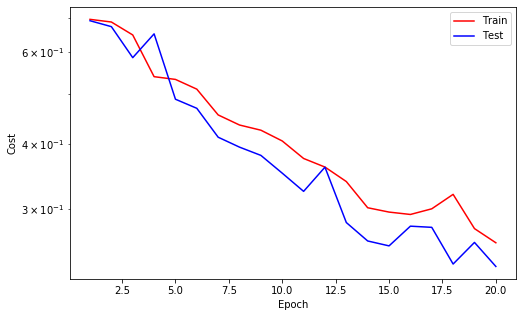

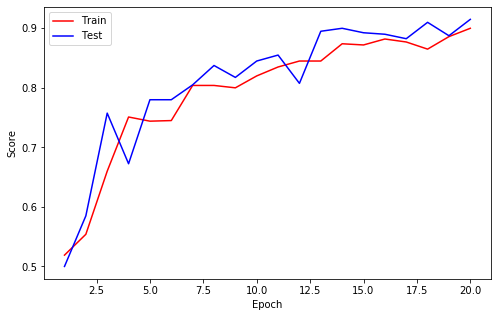



Epoch    21
Train_cost  = 0.2502 | Test_cost  = 0.2230 | Train_score = 0.9050 | Test_score = 0.9150 |
==> EarlyStop patience =  1 | Best test_score: 0.9150




Epoch    22
Train_cost  = 0.2363 | Test_cost  = 0.2133 | Train_score = 0.9070 | Test_score = 0.9200 |




Epoch    23
Train_cost  = 0.2401 | Test_cost  = 0.2229 | Train_score = 0.9130 | Test_score = 0.9100 |
==> EarlyStop patience =  1 | Best test_score: 0.9200




Epoch    24
Train_cost  = 0.2337 | Test_cost  = 0.2128 | Train_score = 0.9050 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9200




Epoch    25
Train_cost  = 0.2271 | Test_cost  = 0.1994 | Train_score = 0.9070 | Test_score = 0.9250 |




Epoch    26
Train_cost  = 0.2200 | Test_cost  = 0.2008 | Train_score = 0.9190 | Test_score = 0.9175 |
==> EarlyStop patience =  1 | Best test_score: 0.9250




Epoch    27
Train_cost  = 0.2142 | Test_cost  = 0.1880 | Train_score = 0.9300 | Test_score = 0.9200 |
==> EarlyStop patience =  2 | Best test_score: 0.9250




Epoch    28
Train_cost  = 0.2016 | Test_cost  = 0.1923 | Train_score = 0.9170 | Test_score = 0.9250 |
==> EarlyStop patience =  3 | Best test_score: 0.9250




Epoch    29
Train_cost  = 0.1951 | Test_cost  = 0.1834 | Train_score = 0.9240 | Test_score = 0.9300 |




Epoch    30
Train_cost  = 0.1872 | Test_cost  = 0.1842 | Train_score = 0.9260 | Test_score = 0.9300 |
==> EarlyStop patience =  1 | Best test_score: 0.9300




Epoch    31
Train_cost  = 0.1794 | Test_cost  = 0.1898 | Train_score = 0.9250 | Test_score = 0.9225 |
==> EarlyStop patience =  2 | Best test_score: 0.9300




Epoch    32
Train_cost  = 0.1860 | Test_cost  = 0.2081 | Train_score = 0.9300 | Test_score = 0.9275 |
==> EarlyStop patience =  3 | Best test_score: 0.9300




Epoch    33
Train_cost  = 0.1719 | Test_cost  = 0.1741 | Train_score = 0.9250 | Test_score = 0.9325 |




Epoch    34
Train_cost  = 0.1646 | Test_cost  = 0.1798 | Train_score = 0.9300 | Test_score = 0.9225 |
==> EarlyStop patience =  1 | Best test_score: 0.9325




Epoch    35
Train_cost  = 0.1845 | Test_cost  = 0.1751 | Train_score = 0.9320 | Test_score = 0.9300 |
==> EarlyStop patience =  2 | Best test_score: 0.9325




Epoch    36
Train_cost  = 0.1560 | Test_cost  = 0.2230 | Train_score = 0.9390 | Test_score = 0.9275 |
==> EarlyStop patience =  3 | Best test_score: 0.9325




Epoch    37
Train_cost  = 0.1636 | Test_cost  = 0.1691 | Train_score = 0.9370 | Test_score = 0.9300 |
==> EarlyStop patience =  4 | Best test_score: 0.9325




Epoch    38
Train_cost  = 0.1564 | Test_cost  = 0.2135 | Train_score = 0.9390 | Test_score = 0.9200 |
==> EarlyStop patience =  5 | Best test_score: 0.9325
==> Execute Early Stopping at epoch: 38 | Best test_score: 0.9325
==> Best model is saved at model


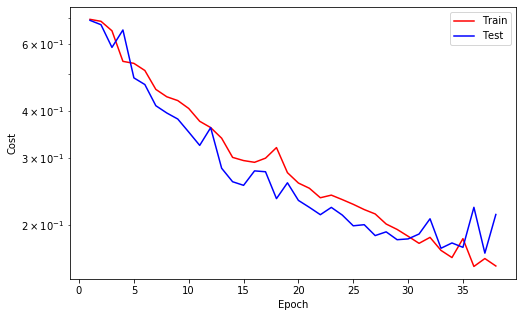

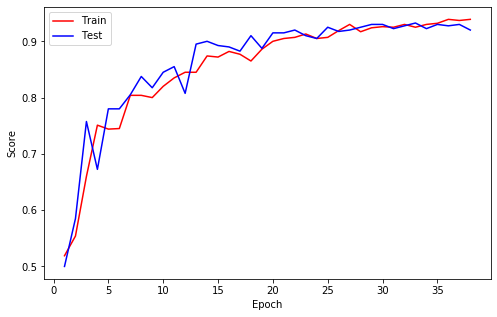

In [69]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict



In [77]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [78]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0])

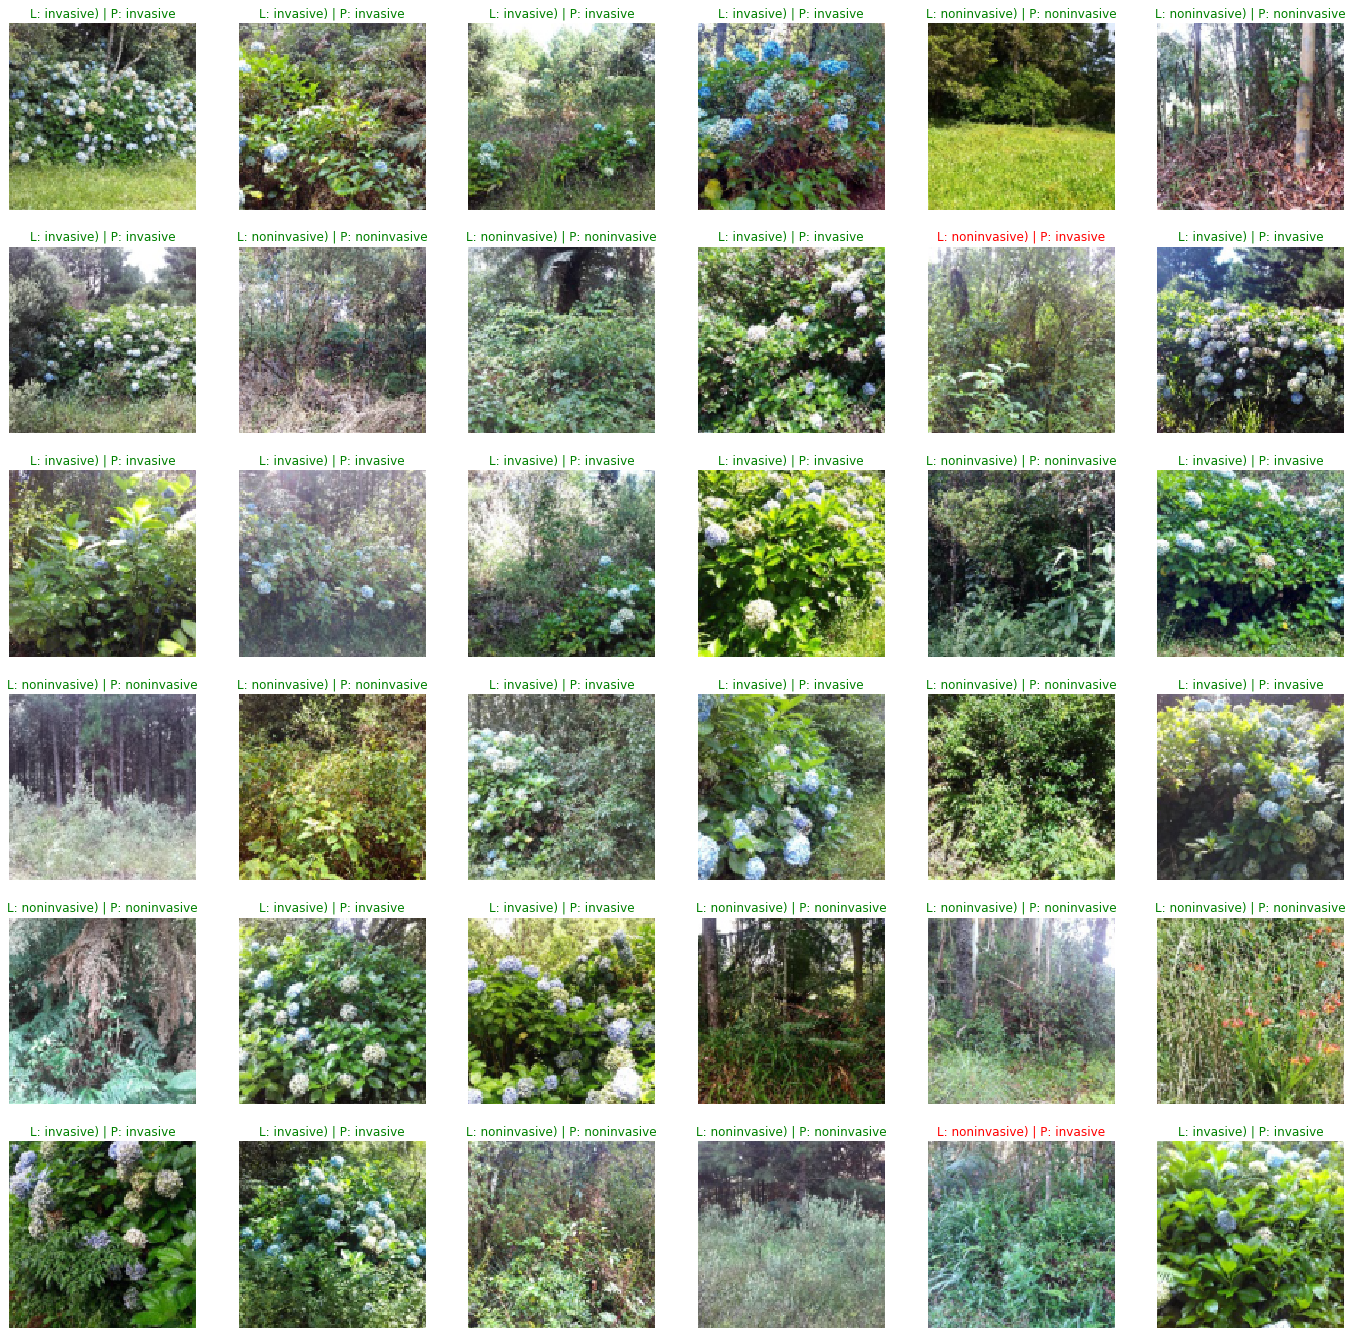

In [79]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color" : 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label}) | P: {pred}", fontdict=font);
    ax.axis('off');
    